In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter, ParameterVector
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

def compute_H(eps, t, delta, num_sites):

    H = 0
    H += eps / 2 * ((I ^ I) - (I ^ Z))
    H += t / 2 * (Y ^ Y) + t / 2 * (X ^ X) 
    H += delta / 2 * (X ^ X) - delta / 2 * (Y ^ Y)
    H += eps / 2 * ((I ^ I) - (Z ^ I))

    return H

num_sites = 2
# Parameterized hopping strengths
eps_param = Parameter("ε")
t_param = Parameter("t")
delta_param = Parameter("Δ")
H_param = compute_H(eps_param, t_param, delta_param, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliSumOp(SparsePauliOp(['II', 'IZ'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5), SummedOp([PauliOp(Pauli('YY'), coeff=0.5), PauliOp(Pauli('XX'), coeff=0.5)], coeff=1.0, abelian=False), PauliOp(Pauli('XX'), coeff=1.0), PauliOp(Pauli('YY'), coeff=-1.0), PauliSumOp(SparsePauliOp(['II', 'ZI'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5)], coeff=1.0, abelian=False)

### Classical simulation Number operator

In [11]:
from operators import n_op
from functions import exact_time_evolution

#n_is = n_op(num_sites)
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]
#Parameters for simulation
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)

# Plot the time evolution
H_1 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
H_2 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})
H_3 = H_param.bind_parameters({eps_param: 10, t_param: 1, delta_param: 0.5})

initial_state_1 = One ^ Zero
n_H1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_1, times, num_sites)
n_H2_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_1, times, num_sites)
n_H3_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_3, n_is, initial_state_1, times, num_sites)

initial_state_2 = One ^ One #(1 / np.sqrt(2))*(Zero ^ Zero) + (1 / np.sqrt(2))*(One ^ One)
n_H1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_2, times, num_sites)
n_H2_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_2, times, num_sites)
n_H3_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_3, n_is, initial_state_2, times, num_sites)

100%|██████████| 500/500 [00:12<00:00, 39.69it/s]


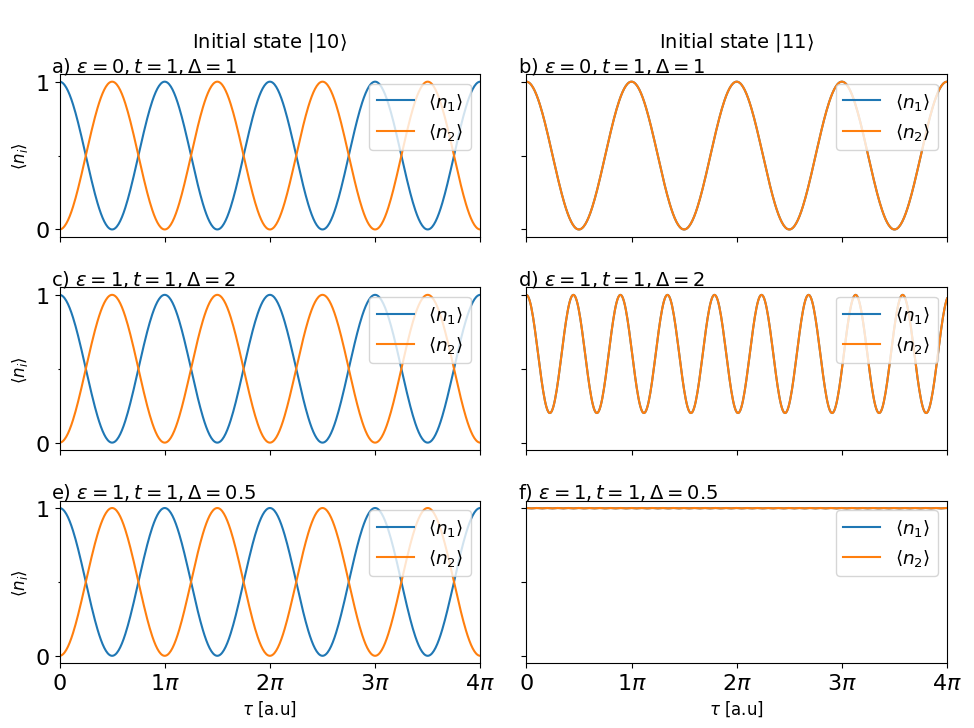

In [12]:
# Define plot labels and ticks
num_op_labels = [rf"$\langle n_{i+1} \rangle$" for i in range(num_sites)]
xticks = np.linspace(0, time_max * np.pi, time_max + 1)
xtick_labels = [rf'${i}\pi$' if i != 0 else '0' for i in range(time_max + 1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1']

# --- Create 3x2 Subplot Grid ---
fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True) # Adjusted figsize for 3 rows

# --- Column 1: Initial State |100> ---
axs[0, 0].plot(times, n_H1_evo_matrix_state_1)
axs[1, 0].plot(times, n_H2_evo_matrix_state_1)
axs[2, 0].plot(times, n_H3_evo_matrix_state_1)
axs[0, 0].set_title(r"Initial state $|10\rangle$", fontsize=14, pad=20)


# --- Column 2: Initial State |010> ---
axs[0, 1].plot(times, n_H1_evo_matrix_state_2)
axs[1, 1].plot(times, n_H2_evo_matrix_state_2)
axs[2, 1].plot(times, n_H3_evo_matrix_state_2)
axs[0, 1].set_title(r"Initial state $|11\rangle$", fontsize=14, pad=20)

# --- Row & Corner Labels ---
# Note: The content of your labels is preserved.
corner_labels = [[r'a) $\varepsilon = 0, t=1, \Delta=1$', r'b) $\varepsilon = 0, t=1, \Delta=1$'],
                 [r'c) $\varepsilon = 1, t=1, \Delta = 2$', r'd) $\varepsilon = 1, t=1, \Delta = 2$'],
                 [r'e) $\varepsilon = 1, t=1, \Delta = 0.5$', r'f) $\varepsilon = 1, t=1, \Delta = 0.5$']]

# --- CORRECTED: Loop for Labels and Text ---
# This loop now correctly iterates through the 3x2 grid.

# --- CORRECTED: Set Axis Labels ---
# Y-labels are set for each plot in the first column.
for r in range(3): # Iterate through 3 rows
    axs[r, 0].set_ylabel(rf"$\langle n_i \rangle$", fontsize=12)
    if r == 2: # X-labels only on the bottom row
        for c_xlabel in range(2):
            axs[r, c_xlabel].set_xlabel(rf"$\tau$ [a.u]", fontsize=12)

    for c in range(2): # Iterate through 2 columns
        axs[r, c].text(-0.02, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# --- CORRECTED: Set tick labels only on the outer plots ---
# For the bottom row (index 2)
for ax in axs[2, :]:
    ax.set_xticklabels(xtick_labels)
# For the left column (index 0)
for ax in axs[:, 0]:
    ax.set_yticklabels(ytick_labels)

# --- Customize Y-Tick Length ---
default_tick_length = plt.rcParams['ytick.major.size']
for ax in axs[:, 0]:
    y_ticks = ax.yaxis.get_major_ticks()
    for tick in y_ticks:
        if tick.get_loc() == 0.5:
            tick.tick1line.set_markersize(default_tick_length / 2)

# --- Final Figure Adjustments ---
# Use the handles from one of the plots to create a single figure-level legend.
handles, labels = axs[0, 0].get_legend_handles_labels()
# You can generate labels dynamically if each line in your plot has one.
# For now, using your num_op_labels for the legend.
fig.legend(handles, num_op_labels, loc='upper right',
           bbox_to_anchor=(0.99, 0.96), frameon=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap
plt.savefig('figures/2-site-kitaev/site-prob-multi-10-11.pdf')

plt.show()

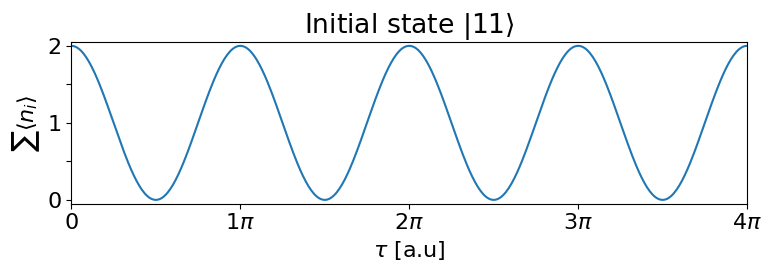

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_H1_evo_matrix_state_2, axis=1))
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel(r"$\sum \langle n_i \rangle $")
plt.title(r'Initial state $|11\rangle$')
plt.ylim([-0.05, 2.05])
plt.xlim(0, 4*np.pi)
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.tight_layout()
plt.savefig('figures/2-site-kitaev/2-site-particle-count.pdf')

### Classical simulation: Pair correlation

In [14]:
from operators import corr_op
from functions import exact_time_evolution

#Parameters for simulation
cc_is = [
    0.25*(Y ^ Y) - 0.25j*(X ^ Y) - 0.25j*(X ^ Y) - 0.25*(X ^ X)
]
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)

H_1 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
H_2 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})

initial_state_1 = One ^ Zero
cc_H1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, cc_is, initial_state_1, times, num_sites)
cc_H2_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, cc_is, initial_state_1, times, num_sites)

initial_state_2 = (1 / np.sqrt(2))*(Zero ^ Zero) + (1 / np.sqrt(2))*(One ^ One)
cc_H1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, cc_is, initial_state_2, times, num_sites)
cc_H2_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, cc_is, initial_state_2, times, num_sites)

 66%|██████▌   | 328/500 [00:07<00:04, 42.02it/s]


KeyboardInterrupt: 

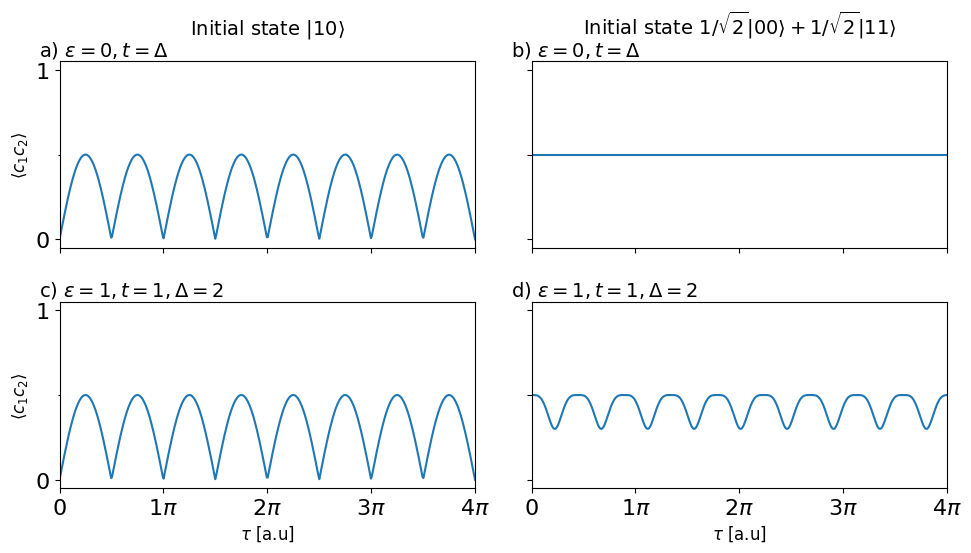

In [ ]:
# --- Plotting Setup ---
# Assuming 'times' and the four 'n_..._evo_matrix_...' variables exist
num_sites = 3

# Define plot labels and ticks
xticks = np.linspace(0, time_max*np.pi, time_max+1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max+1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1']

# --- Create 2x2 Subplot Grid ---
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

# --- Column 1: Initial State |100> ---
axs[0, 0].plot(times, cc_H1_evo_matrix_state_1[:,0])
axs[1, 0].plot(times, cc_H2_evo_matrix_state_1[:,0])
axs[0, 0].set_title(r"Initial state $|10\rangle$", fontsize=14, pad=20)
# --- Column 2: Initial State |010> ---
axs[0, 1].plot(times, cc_H1_evo_matrix_state_2[:,0])
axs[1, 1].plot(times, cc_H2_evo_matrix_state_2[:,0])
axs[0, 1].set_title(r"Initial state $1/\sqrt{2}|00\rangle + 1/\sqrt{2}|11\rangle$", fontsize=14, pad=20)

# --- Row & Corner Labels ---
corner_labels = [[r'a) $\varepsilon = 0, t=\Delta$', r'b) $\varepsilon = 0, t=\Delta$'], [r'c) $\varepsilon = 1, t=1, \Delta = 2$', r'd) $\varepsilon = 1, t=1, \Delta = 2$']]

for r in range(2):
    axs[r, 0].set_ylabel(rf"$\langle c_1c_2 \rangle$", fontsize=12)
    axs[1, r].set_xlabel(rf"$\tau$ [a.u]", fontsize=12)

    for c in range(2):
        axs[r, c].text(-0.05, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        #axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
        
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    #ax.grid(linestyle='--', alpha=0.6)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
for ax in axs[1, :]:  # Bottom row
    ax.set_xticklabels(xtick_labels)
for ax in axs[:, 0]:  # Left column
    ax.set_yticklabels(ytick_labels)

# --- CORRECTED: Customize Y-Tick Length ---
# Get the default major tick length to use as a reference
default_tick_length = plt.rcParams['ytick.major.size']

# Loop through the axes in the left column where y-ticks are visible
for ax in axs[:, 0]:
    # Get the list of major tick objects for the y-axis
    y_ticks = ax.yaxis.get_major_ticks()
    for tick in y_ticks:
        # Check if the tick's position is 0.5
        if tick.get_loc() == 0.5:
            # CORRECT: Modify the 'markersize' of the tick's line object
            tick.tick1line.set_markersize(default_tick_length / 2)


# --- Final Figure Adjustments ---
handles, _ = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, num_op_labels, loc='upper right', 
           #bbox_to_anchor=(0.99, 0.96), frameon=False) # Add frameon=False
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('figures/2-site-kitaev/cc-prob-multi.pdf')
# --- Display the plot ---
plt.show()

### Classical simulation corr dagger op

In [ ]:
#Number operator
from operators import corr_dagger_op
from functions import exact_time_evolution

cc_dagger_is = corr_dagger_op(num_sites,0,1)

time_max = 4
times = np.linspace(0, time_max * np.pi, 500)

H_1 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
H_2 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})

initial_state_1 = One ^ Zero
cc_dagger_H1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, cc_dagger_is, initial_state_1, times, num_sites)
cc_dagger_H2_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, cc_dagger_is, initial_state_1, times, num_sites)

initial_state_2 = (1 / np.sqrt(2))*(One ^ Zero) + (1 / np.sqrt(2))*(Zero ^ One)
cc_dagger_H1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, cc_dagger_is, initial_state_2, times, num_sites)
cc_dagger_H2_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, cc_dagger_is, initial_state_2, times, num_sites)

  0%|          | 0/500 [00:00<?, ?it/s]


QiskitError: 'Invalid input: not a vector or column-vector.'

NameError: name 'cc_dagger_H1_evo_matrix_state_1' is not defined

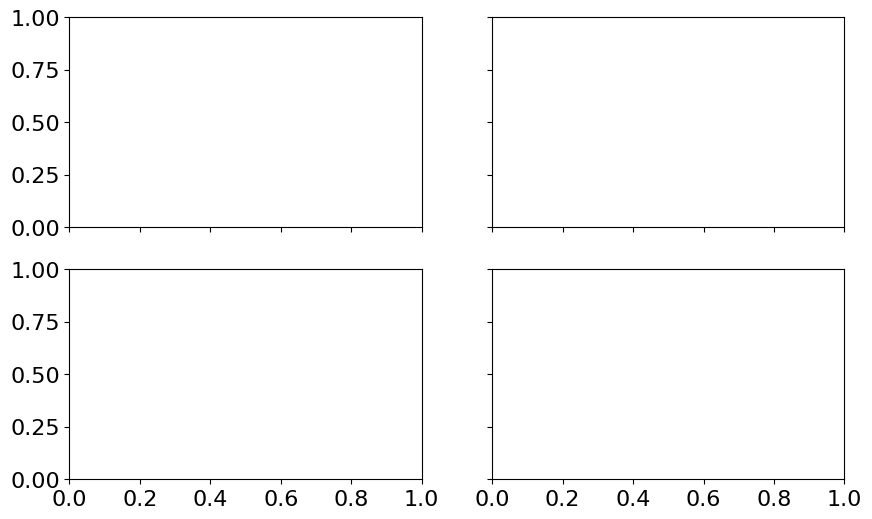

In [ ]:
# --- Plotting Setup ---
# Assuming 'times' and the four 'n_..._evo_matrix_...' variables exist
num_sites = 3

# Define plot labels and ticks
xticks = np.linspace(0, time_max*np.pi, time_max+1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max+1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1']

# --- Create 2x2 Subplot Grid ---
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

# --- Column 1: Initial State |100> ---
axs[0, 0].plot(times, cc_dagger_H1_evo_matrix_state_1[:,0])
axs[1, 0].plot(times, cc_dagger_H2_evo_matrix_state_1[:,0])
axs[0, 0].set_title(r"Initial state $|10\rangle$", fontsize=14, pad=20)

# --- Column 2: Initial State |010> ---
axs[0, 1].plot(times, cc_dagger_H1_evo_matrix_state_2[:,0])
axs[1, 1].plot(times, cc_dagger_H2_evo_matrix_state_2[:,0])
axs[0, 1].set_title(r"Initial state $1/\sqrt{2}|10\rangle + 1/\sqrt{2}|01\rangle$", fontsize=14, pad=20)

# --- Row & Corner Labels ---
corner_labels = [[r'a) $\varepsilon = 0, t=\Delta$', r'b) $\varepsilon = 0, t=\Delta$'], [r'c) $\varepsilon = 1, t=1, \Delta = 2$', r'd) $\varepsilon = 1, t=1, \Delta = 2$']]

for r in range(2):
    axs[r, 0].set_ylabel(rf"$\langle c_1^\dagger c_2^\dagger \rangle$", fontsize=12)
    axs[1, r].set_xlabel(rf"$\tau$ [a.u]", fontsize=12)

    for c in range(2):
        axs[r, c].text(-0.05, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        #axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
        
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    #ax.grid(linestyle='--', alpha=0.6)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
for ax in axs[1, :]:  # Bottom row
    ax.set_xticklabels(xtick_labels)
for ax in axs[:, 0]:  # Left column
    ax.set_yticklabels(ytick_labels)

# --- CORRECTED: Customize Y-Tick Length ---
# Get the default major tick length to use as a reference
default_tick_length = plt.rcParams['ytick.major.size']

# Loop through the axes in the left column where y-ticks are visible
for ax in axs[:, 0]:
    # Get the list of major tick objects for the y-axis
    y_ticks = ax.yaxis.get_major_ticks()
    for tick in y_ticks:
        # Check if the tick's position is 0.5
        if tick.get_loc() == 0.5:
            # CORRECT: Modify the 'markersize' of the tick's line object
            tick.tick1line.set_markersize(default_tick_length / 2)


# --- Final Figure Adjustments ---
handles, _ = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, num_op_labels, loc='upper right', 
           #bbox_to_anchor=(0.99, 0.96), frameon=False) # Add frameon=False
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('figures/2-site-kitaev/cc-dagger-multi.pdf')
# --- Display the plot ---
plt.show()

### Particle count

In [ ]:
path = base_path + "2-site-particle-count.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_evo_matrix, axis=1))
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel("sum of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.xlim(0, 8*np.pi)
plt.tight_layout()
plt.savefig(path)

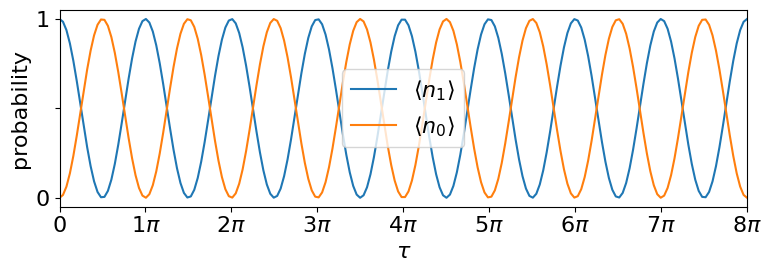

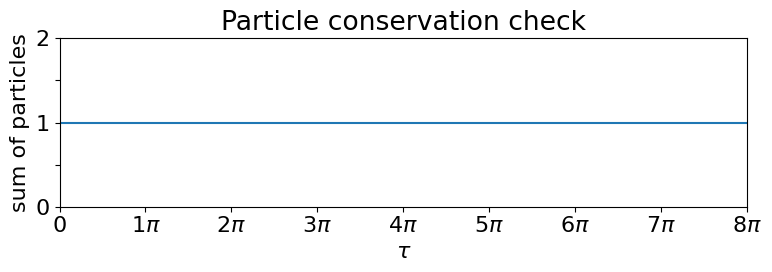

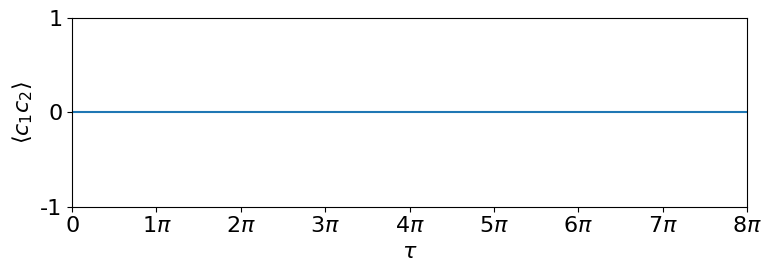

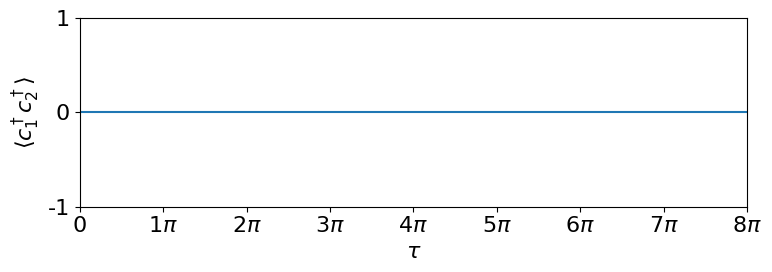

In [ ]:

path = base_path + "2-site-corr_nb.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(cc_evo_matrix, axis=1))
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel(r"$\langle c_1 c_2 \rangle$")
plt.yticks([-1, 0, 1], ['-1','0', '1'])
plt.xticks(xticks, xtick_labels)
plt.xlim(0, 8*np.pi)
plt.tight_layout()
plt.savefig(path)

path = base_path + "2-site-corr-dagger_nb.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(cc_dagger_evo_matrix, axis=1))
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel(r"$\langle c_1^\dagger c_2^\dagger \rangle$")
plt.yticks([-1, 0, 1], ['-1','0', '1'])
plt.xticks(xticks, xtick_labels)
plt.xlim(0, 8*np.pi)
plt.tight_layout()
plt.savefig(path)

# path = base_path + "2-site-energy.pdf"
# plt.figure(figsize=(10, 6))
# plt.imshow(
#     E_evo_full,
#     aspect='auto',
#     extent=[times[0], times[-1], p_values[0], p_values[-1]],
#     origin='lower',
#     cmap='viridis'
# )
# plt.colorbar(label='Energy')
# plt.title(r'Energy for initial states $p|10\rangle + (1-p)|01\rangle$')
# plt.xlabel(r'$\tau$ [a.u]')
# plt.xticks(xticks, xtick_labels)
# plt.ylabel('p')
# plt.tight_layout()

plt.show()

### Trotterization

In [ ]:
import sys
sys.exit("Stopping here")
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution

# Number of trotter steps
trotter_steps = 8

# Calculate each number operator's expectation value at each time point and store in a 2D array
n_evo_matrix_trot = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps)

# Plot the time evolution
path = base_path + "2-site-prob-trotter.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, n_evo_matrix_trot)
plt.xlabel("time")
plt.ylabel("probability")
plt.title(f"Probability of occupying a given site at m = {trotter_steps}")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

SystemExit: Stopping here

/home/oscartq/miniconda3/envs/article_mzm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Trotter error

In [ ]:
# Number of trotter steps
trotter_steps_1 = 10

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_1)

# Number of trotter steps
trotter_steps_2 = 20
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)

 64%|██████▍   | 129/200 [00:09<00:05, 13.04it/s]


KeyboardInterrupt: 

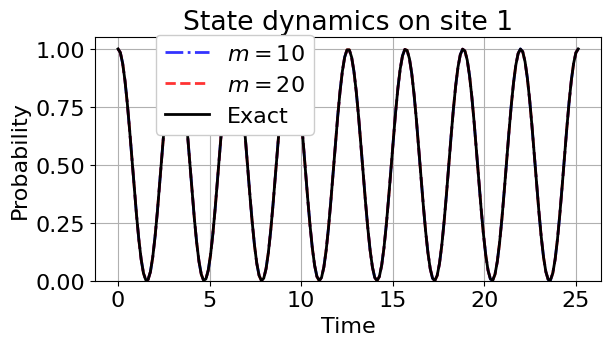

In [ ]:
# Plot state dynamics over one particular site
site = 0
path = base_path + "2-site-state_dynm_site1.pdf"

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_2[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_2}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, n_evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.savefig(path)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.54s/it]


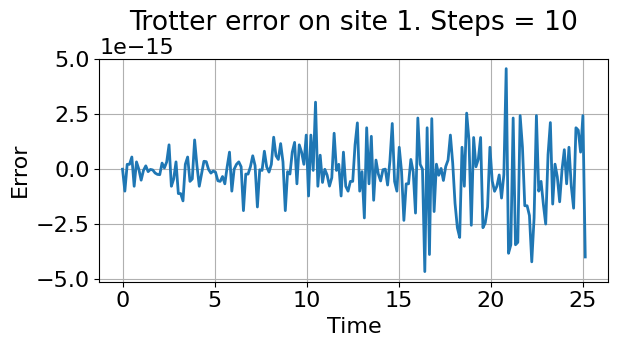

In [ ]:
# Number of trotter steps
trotter_steps_error = 10
path = base_path + "2-site-trotter_error_site1.pdf"

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error)

# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    n_evo_matrix[:, site]-evo_matrix_trot_error[:, site],
    linewidth=2
)

plt.xlabel("Time")
plt.ylabel("Error")
plt.grid()
plt.title("Trotter error on site " + str(site+1) + f". Steps = {trotter_steps_error}")
plt.tight_layout()
plt.savefig(path)
plt.show()

### Generate circuit diagram

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [ ]:
from functions import compute_U_trot
H = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
#print(latex_code)
with open("circuits/2-site-circuit.tex", "w") as f:
    f.write(latex_code)


TypeError: Trotterization converters can only convert SummedOp or PauliSumOp.